В этом дз необходимо обучить модели для классификации. Cегодня попробуем отличать настоящие новости от фейковых



In [3]:
# ячейка импортов

import numpy as np
import pandas as pd

# импорт моделей
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score # табличка с метриками

from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

# Exploratory Data Analysis (EDA)



In [4]:
data = pd.read_csv("news_fake-n-true.csv")
data.head(2)

,Unnamed: 0,title,text,subject,date,label
0,0,ADVISORY: Story on Kushner visiting Iraq withd...,(Reuters) - The story “Trump son-in-law Jared ...,politicsNews,"April 3, 2017",1
1,1,Kasich campaign denies report of Romney endors...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 14, 2016",1


**колонка label отвечает за тип новости: настоящие имеют лейбл 1,  фейковые новости -- с лейблом 0** 

In [5]:
# создадим новый датафрейм из старого

data_clean = data.drop(['Unnamed: 0','title','subject','date'], axis=1)

data_clean.head(2)

,text,label
0,(Reuters) - The story “Trump son-in-law Jared ...,1
1,WASHINGTON (Reuters) - Republican presidential...,1


распределение настоящих и фейковых новостей примерно равное

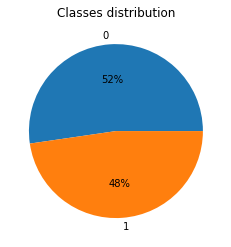

In [10]:
classes = pd.value_counts(data_clean["label"])

classes.plot(kind = 'pie',  autopct='%0.f%%') 
plt.title("Classes distribution")
plt.ylabel('')

plt.show()

**давайте попробуем предсказать:** окажется ли текст настоящей новостью или фейковой

- Векторизуйте тексты
- Разделите данные на обучающую и тестовую выборку

Попробуйте обучить разные модели для классификации на данных
1. Naive Bayes
2. SVM 
3. Decision Trees
4. Random Forest
5. Boosting

Для каждой модели посмотрите на метрики с помощью функции [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

Какая/какие модель/ли справляются с задачей наиболее эффективно?

### Подготовка данных 

In [6]:
# импорты для препроцессинга
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
en_sws = stopwords.words('english')
from string import punctuation

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re

from functools import lru_cache

from tqdm.notebook import tqdm

In [7]:
punctuation += '“”’'

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
# функция, возвращающая список токенов с сохранением пунктуации внутри слов
def get_tokens(text):
    tokens = [word.strip(punctuation) for word in word_tokenize(text)]
    clean_tokens = [word.lower() for word in tokens if word]
    return clean_tokens 

In [10]:
@lru_cache(maxsize=128)
def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

def lemmatize_text(tokens):
    return [lemmatize_word(w) for w in tokens]

In [11]:
def remove_stopwords(lemmas, stopwords = en_sws):
    return [w for w in lemmas if not w in stopwords]

In [12]:
def preprocessing(text):
    tokens = get_tokens(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [13]:
print('Обработанный текст:', preprocessing(data_clean['text'][0]), '\n')
print('Сырой текст:', data_clean['text'][0])

Обработанный текст: reuters story trump son-in-law jared kushner visit iraq u.s official say accompanying alert subsequent update wrong withdrawn substitute story available 

Сырой текст: (Reuters) - The story “Trump son-in-law Jared Kushner visits Iraq, U.S. official says”, the accompanying alert and subsequent update are wrong and were withdrawn. A substitute story is available here


In [14]:
lemmas = list(tqdm(map(preprocessing, data_clean['text']), total=len(data_clean['text'])))

In [15]:
data_preprocessed = data_clean
data_preprocessed['text'] = lemmas

In [14]:
data_preprocessed.head(2)

,text,label
0,reuters story trump son-in-law jared kushner visit iraq u.s official say accompanying alert subsequent update wrong withdrawn substitute story available,1
1,washington reuters republican presidential candidate john kasich campaign monday denied report mitt romney party presidential candidate 2012 would endorse ohio governor monday wall street journal reporter said kasich answered affirmative question romney endorsement kasich spokesman chris schrimpf said true kasich wa responding acknowledging different question romney endorsement would provided kasich boost eve ohio primary front-runner donald trump running close race first place,1


### Настройка моделей 

In [92]:
# модели, которые попробуем обучить
svc = svm.SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = naive_bayes.MultinomialNB(alpha=0.33001)
dtc = DecisionTreeClassifier(min_samples_leaf=5, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(min_samples_split=7, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=111)
bc = BaggingClassifier(n_estimators=50, random_state=111)
etc = ExtraTreesClassifier(random_state=111)

(для справки - разница между Random Forest/Bagging)
![для справки - разница между Random Forest/Bagging](https://i.stack.imgur.com/sYR7y.png)

In [94]:
clfs = {'SVC' : svc,'KNeibourghs' : knc, 'NaiveBayes': mnb, 'DecisionTree': dtc, 'LogisticRegression': lrc, 
        'RandomForest': rfc, 'AdaBoost': abc, 'BaggingClf': bc, 'ExtraTreeClassifier': etc, 'GradientBoost': gbc}

In [95]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [96]:
def predict_labels(clf, features):
    return (clf.predict(features))

### Обучение

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_preprocessed['text'], 
                                                    data_preprocessed['label'], 
                                                    test_size=0.3, 
                                                    random_state=59)

In [201]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=3)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [99]:
pred_scores = []
for k,v in tqdm(clfs.items(), total=10):
    train_classifier(v, X_train, y_train)
    pred = predict_labels(v,X_test)
    pred_scores.append((k, [accuracy_score(y_test,pred), metrics.precision_score(y_test, pred)]))
    print(f'{k}:\n{classification_report(y_test, pred)}\n')

SVC:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7034
           1       0.99      0.99      0.99      6436

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470


KNeibourghs:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      7034
           1       0.98      0.05      0.09      6436

    accuracy                           0.54     13470
   macro avg       0.76      0.52      0.39     13470
weighted avg       0.75      0.54      0.41     13470


NaiveBayes:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7034
           1       0.95      0.94      0.94      6436

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.9

In [100]:
df = pd.DataFrame.from_dict(dict(pred_scores), orient='index', columns=['Accuracy Score', 'Precision Score'])
df.sort_values(['Accuracy Score'])

,Accuracy Score,Precision Score
KNeibourghs,0.544024,0.983553
NaiveBayes,0.945805,0.945225
ExtraTreeClassifier,0.991537,0.988261
SVC,0.994506,0.993637
LogisticRegression,0.995323,0.993648
RandomForest,0.995620,0.995647
DecisionTree,0.996140,0.996577
GradientBoost,0.996437,0.994427
AdaBoost,0.997105,0.997202
BaggingClf,0.997773,0.997824


##### Лучше всего справился Bagging Classifier (и в целом ансамбли).

Можно посмотреть на самые значимые признаки:

In [103]:
# Random Forest Classifier
forest_df = pd.DataFrame(rfc.feature_importances_)

forest_df["feature"] = vectorizer.get_feature_names()
forest_df.nlargest(10, 0)

,0,feature
31725,0.089446,reuters
39755,0.029564,via
37225,0.023727,the
32641,0.023501,said
14602,0.014415,featured
40285,0.009338,washington
24463,0.007921,minister
37466,0.007752,thursday
40304,0.007455,watch
18909,0.007184,image


In [134]:
# Bagging Classifier
feature_importances = np.mean([
    tree.feature_importances_ for tree in bc.estimators_
], axis=0)
bagg_df = pd.DataFrame(feature_importances)

bagg_df["feature"] = vectorizer.get_feature_names()
bagg_df.nlargest(10, 0)

,0,feature
31725,0.970153,reuters
37225,0.009945,the
16238,0.003326,getty
39755,0.001135,via
33793,0.000814,she
28299,0.000761,pic
25812,0.000641,news
979,0.000603,21wire
18824,0.000438,ifr
40608,0.000417,while


#### Нейронная сеть 

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.layers import Embedding, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential

In [19]:
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 300

In [20]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
word_index = tokenizer.word_index

In [22]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_SEQUENCE_LENGTH)

In [23]:
path = '/Users/darapetruhnenko/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

In [24]:
def get_embeddings(path):
    
    wv_model = KeyedVectors.load_word2vec_format(path, binary=True, limit=500000) 
    embeddings_index = {}
    for word, vector in zip(wv_model.key_to_index, wv_model.vectors):
        coefs = np.asarray(vector, dtype='float32')
        embeddings_index[word] = coefs
  
    return embeddings_index

In [25]:
embeddings_index = get_embeddings(path)

In [26]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [27]:
del embeddings_index

In [32]:
def lstm_net1():
    model = Sequential()

    model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(LSTM(units=128 , return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32 , activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [33]:
model = lstm_net1()

batch_size = 256
epochs = 8

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30034200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [34]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10)

Epoch 1/10
123/123 [==============================] - 774s 6s/step - loss: 0.4300 - accuracy: 0.8244 - val_loss: 0.1484 - val_accuracy: 0.9475
Epoch 2/10
123/123 [==============================] - 786s 6s/step - loss: 0.1348 - accuracy: 0.9541 - val_loss: 0.1000 - val_accuracy: 0.9661
Epoch 3/10
123/123 [==============================] - 897s 7s/step - loss: 0.1290 - accuracy: 0.9520 - val_loss: 0.0988 - val_accuracy: 0.9720
Epoch 4/10
123/123 [==============================] - 877s 7s/step - loss: 0.0682 - accuracy: 0.9794 - val_loss: 0.0815 - val_accuracy: 0.9745
Epoch 5/10
123/123 [==============================] - 879s 7s/step - loss: 0.0738 - accuracy: 0.9728 - val_loss: 0.1222 - val_accuracy: 0.9585
Epoch 6/10
123/123 [==============================] - 835s 7s/step - loss: 0.1206 - accuracy: 0.9561 - val_loss: 0.0520 - val_accuracy: 0.9819
Epoch 7/10
123/123 [==============================] - 752s 6s/step - loss: 0.0695 - accuracy: 0.9788 - val_loss: 0.2637 - val_accuracy: 0.8843

In [39]:
accr_test = model.evaluate(X_test,y_test)
print(f'Accuracy Score: {accr_test[1]*100}')
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred))

421/421 [==============================] - 140s 331ms/step - loss: 0.0183 - accuracy: 0.9941
Accuracy Score: 99.41351413726807
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7034
           1       1.00      0.99      0.99      6436

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



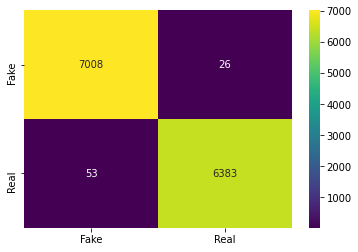

In [43]:
cf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'], cmap='viridis')
plt.show()

<AxesSubplot:>

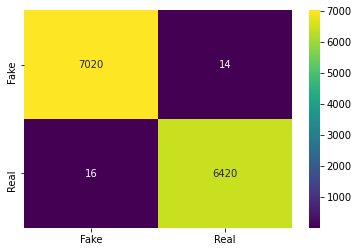

In [203]:
pred_bc = predict_labels(bc, X_test)
cf_matrix = confusion_matrix(y_test, pred_bc)
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'], cmap='viridis')
plt.show()

В данном случае ансмабли работают лучше, чем нейронная сеть. Точность очень близка к 100%